# Kuramoto Model

Plot saved at /home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Bifurcation Analysis/Dipole/Kuramoto_Brain_Regions_Plot.png
Kuramoto phases saved at /home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Bifurcation Analysis/Dipole/kuramoto_phases.npy


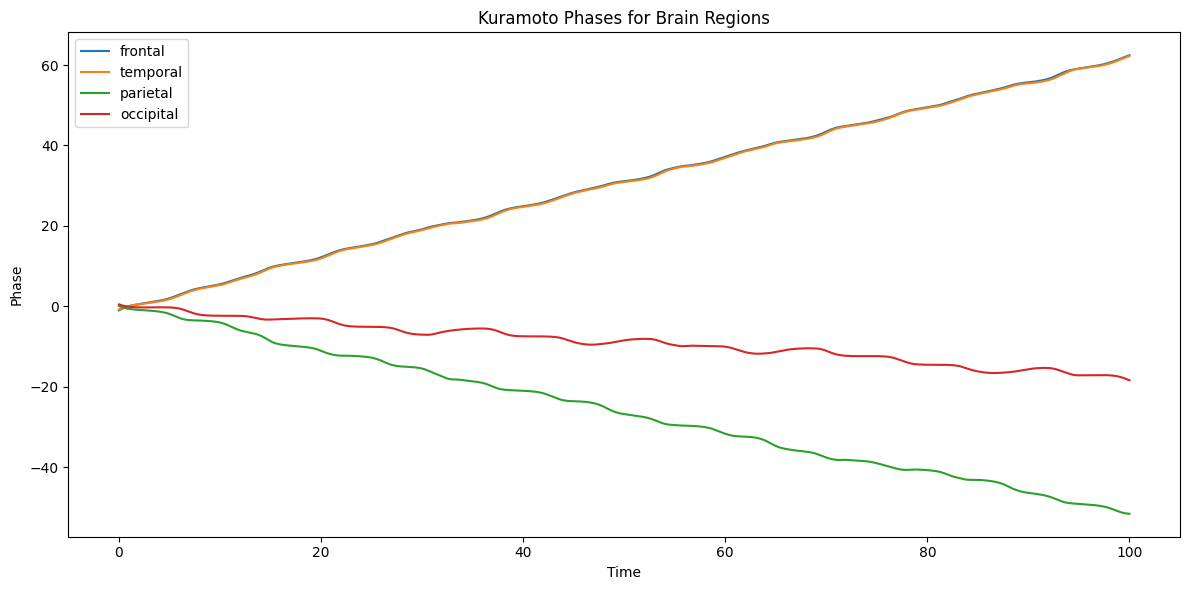

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import os

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Broad regions and corresponding channels
regions = {
    "frontal": ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    "temporal": ['T7', 'T8'],
    "parietal": ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8'],
    "occipital": ['O1', 'Oz', 'O2']
}

# Hilbert transform to get analytical signal
analytic_signal = hilbert(EEG_data)
phases = np.angle(analytic_signal)

# Average phase for each region
avg_phases = {}
for region, channels in regions.items():
    indices = [eeg_channel_names.index(ch) for ch in channels]
    avg_phases[region] = np.mean(phases[0, indices])

N = len(regions)  # Number of regions
K = 1.0  # Coupling strength
omega = np.random.uniform(-1, 1, N)  # Natural frequencies for each region

# Kuramoto differential equations
def kuramoto(t, y, omega, K):
    dydt = omega + K/N * np.sum(np.sin(y - y[:, np.newaxis]), axis=1)
    return dydt

# Initial conditions: Average phases from EEG
initial_phases = np.array(list(avg_phases.values()))

# Time span for the simulation
t_span = (0, 100)  # Example
desired_length = len(EEG_data)
t_eval = np.linspace(t_span[0], t_span[1], desired_length)  # Match with the EEG length

# Solve differential equations
solution = solve_ivp(kuramoto, t_span, initial_phases, t_eval=t_eval, args=(omega, K))

# The simulated Kuramoto phases
kuramoto_phases = solution.y

# Plot
plt.figure(figsize=(12, 6))
for i, region in enumerate(regions.keys()):
    plt.plot(t_eval, kuramoto_phases[i, :], label=region)
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Kuramoto Phases for Brain Regions')
plt.legend()
plt.tight_layout()

save_directory = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Bifurcation Analysis/Dipole"

# Check if the directory exists and create it if not
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

plot_path = os.path.join(save_directory, "Kuramoto_Brain_Regions_Plot.png")
plt.savefig(plot_path)


# Save the simulated Kuramoto phases
kuramoto_data_path = os.path.join(save_directory, "kuramoto_phases.npy")
np.save(kuramoto_data_path, kuramoto_phases)

print(f"Plot saved at {plot_path}")
print(f"Kuramoto phases saved at {kuramoto_data_path}")


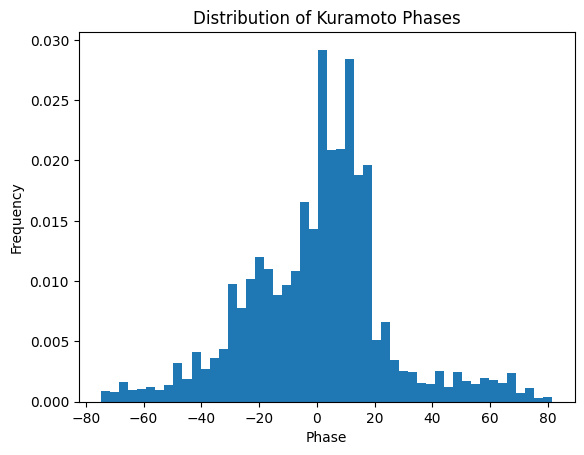

In [18]:
plt.hist(kuramoto_phases.ravel(), bins=50, density=True)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Distribution of Kuramoto Phases')
plt.show()


# Feature Extraction

In [ ]:
# Normalization, since phases from the Kuramoto model will be between 0 and 2*pi, 
normalized_phases = kuramoto_phases / (2 * np.pi)

# Feature Creation
instantaneous_frequency = np.vstack([np.zeros(normalized_phases.shape[0]),
                                     np.diff(normalized_phases, axis=1)])

# Combining both the normalized phases and instantaneous frequency for a richer feature set
features = np.vstack([normalized_phases, instantaneous_frequency]).T

# Printing the head (first 5 rows)
print(features[:5])

# Save the features as a .npy file for future use
np.save('/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto/kuramoto_features.npy', features)


# Bifurcation 

In [ ]:

def compute_order_parameter(phases):
    """Compute the order parameter r from the phases."""
    return np.abs(np.mean(np.exp(1j * phases), axis=0))

# Bifurcation analysis
K_values = np.linspace(0, 5, 50)  # Change the range and number of points as needed
r_values = []

for K in K_values:
    solution = solve_ivp(kuramoto, t_span, initial_phases, t_eval=t_eval, args=(omega, K))
    r = compute_order_parameter(solution.y)
    r_values.append(np.mean(r[-int(desired_length * 0.1):]))  # average of the last 10% to ensure steady-state

# Plot bifurcation diagram
plt.figure(figsize=(12, 6))
plt.plot(K_values, r_values, '-o')
plt.xlabel('Coupling Strength K')
plt.ylabel('Order Parameter r')
plt.title('Bifurcation Diagram of Kuramoto Model')
plt.tight_layout()

bifurcation_plot_path = os.path.join(save_directory, "Kuramoto_Bifurcation_Plot.png")
plt.savefig(bifurcation_plot_path)

print(f"Bifurcation plot saved at {bifurcation_plot_path}")